In [7]:
import pickle

from structured_transitions import MaskedNetwork
import torch
import torch.nn.functional as F
import torch.nn as nn

import matplotlib.pyplot as plt, copy, numpy as np, os
from matplotlib import animation, rc
from IPython.display import HTML

NUM_SPRITES = 4
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from enum import Enum
class RelabelStrategy(Enum):
  NONE = 0
  GROUND_TRUTH = 1
  RANDOM = 2
  
class StateActionStateRelabeledDataset(torch.utils.data.Dataset):
  """Relabels the data up front using relabel_strategy"""
  
  def __init__(self, data, sprites, relabel_strategy=RelabelStrategy.GROUND_TRUTH, 
               relabel_pairs=10000, samples_per_pair=5, custom_get_mask=None):
    if custom_get_mask is not None:
      get_mask = custom_get_mask
    elif relabel_strategy is RelabelStrategy.NONE:
      get_mask = get_fully_connected_mask
    elif relabel_strategy is RelabelStrategy.GROUND_TRUTH:
      get_mask = get_true_flat_mask
    elif relabel_strategy is RelabelStrategy.RANDOM:
      get_mask = get_random_flat_mask
    else:
      raise NotImplementedError
    
    self.data = enlarge_dataset(data, sprites, relabel_pairs, samples_per_pair, 
                                flattened=True, custom_get_mask=get_mask)
    
    self.s1, self.a, _, self.s2 = list(zip(*self.data))
    
    self.s1 = torch.tensor(self.s1).detach()
    self.a = torch.tensor(self.a).detach()
    self.s2 = torch.tensor(self.s2).detach()

  def __len__(self):
    return len(self.s1)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    s1 = self.s1[idx]
    a  = self.a[idx]
    s2 = self.s2[idx]
    return torch.cat((s1, a), 0), s2
  
class StateActionTestDataset(torch.utils.data.Dataset):  
  def __init__(self, data, sprites):
    self.s1, self.a, _, self.s2 = list(zip(*data))
    self.s1 = torch.tensor(self.s1).detach().flatten(start_dim=1)
    self.a = torch.tensor(self.a).detach()
    self.s2 = torch.tensor(self.s2).detach().flatten(start_dim=1)

  def __len__(self):
    return len(self.s1)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    s1 = self.s1[idx]
    a  = self.a[idx]
    s2 = self.s2[idx]
    return torch.cat((s1, a), 0), s2

In [5]:
with open('forward_model_og_2k_relabel_50k.pickle', 'rb') as f:
  tr_none, tr_true, tr_rand, te = pickle.load(f)

In [6]:
print(len(tr_none), len(tr_true), len(tr_rand))
for tr in [tr_none, tr_true, tr_rand]:
  lst = [tr[i][0].numpy().round(2) for i in range(len(tr_none))]
  s = set([tuple(a) for a in lst])
  print("Number of unique (s1, a) pairs in dataset: {}".format(len(s)))

50000 50000 50000
Number of unique (s1, a) pairs in dataset: 2000
Number of unique (s1, a) pairs in dataset: 36789
Number of unique (s1, a) pairs in dataset: 14502


## Training the forward models

In [34]:
def train_fwd_model(tr):
  train_loader = torch.utils.data.DataLoader(tr, batch_size=500, shuffle=True, num_workers=2, drop_last=True)
  test_loader  = torch.utils.data.DataLoader(te, batch_size=500, shuffle=False, num_workers=2, drop_last=True)
  
  model = MaskedNetwork(in_features=NUM_SPRITES*4 + 2, out_features=NUM_SPRITES*4, 
                      num_hidden_layers=2, num_hidden_units=256).to(dev)
  opt = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.MSELoss()
  
  tr_losses = []
  te_losses = []
  for epoch in range(100):
    total_loss = 0.
    for i, (x, y) in enumerate(train_loader):
      pred_y = model(x.to(dev))
      loss = criterion(y.to(dev), pred_y)
      total_loss += loss
      model.zero_grad()
      loss.backward()
      opt.step()
    test_loss = 0.
    for j, (x, y) in enumerate(test_loader):
      pred_y = model(x.to(dev))
      loss = criterion(y.to(dev), pred_y)
      test_loss += loss
    tr_losses.append(float(total_loss / i))
    te_losses.append(float(test_loss / j))
    if epoch % 10 == 0:
      print('Epoch {} done! Train loss: {:.5f}.  Test loss: {:.5f}'.format(epoch, total_loss / i, test_loss / j))

  
  return tr_losses, te_losses

In [35]:
tr_loss_none, te_loss_none = train_fwd_model(tr_none)

Epoch 0 done! Train loss: 0.01702.  Test loss: 0.00155
Epoch 10 done! Train loss: 0.00063.  Test loss: 0.00085
Epoch 20 done! Train loss: 0.00057.  Test loss: 0.00090
Epoch 30 done! Train loss: 0.00053.  Test loss: 0.00094
Epoch 40 done! Train loss: 0.00048.  Test loss: 0.00103
Epoch 50 done! Train loss: 0.00045.  Test loss: 0.00103
Epoch 60 done! Train loss: 0.00042.  Test loss: 0.00107
Epoch 70 done! Train loss: 0.00041.  Test loss: 0.00111
Epoch 80 done! Train loss: 0.00039.  Test loss: 0.00116
Epoch 90 done! Train loss: 0.00037.  Test loss: 0.00116


In [36]:
tr_loss_rand, te_loss_rand = train_fwd_model(tr_rand)

Epoch 0 done! Train loss: 0.01770.  Test loss: 0.00155
Epoch 10 done! Train loss: 0.00069.  Test loss: 0.00081
Epoch 20 done! Train loss: 0.00063.  Test loss: 0.00086
Epoch 30 done! Train loss: 0.00057.  Test loss: 0.00088
Epoch 40 done! Train loss: 0.00054.  Test loss: 0.00093
Epoch 50 done! Train loss: 0.00050.  Test loss: 0.00095
Epoch 60 done! Train loss: 0.00049.  Test loss: 0.00100
Epoch 70 done! Train loss: 0.00047.  Test loss: 0.00101
Epoch 80 done! Train loss: 0.00045.  Test loss: 0.00104
Epoch 90 done! Train loss: 0.00043.  Test loss: 0.00107


In [37]:
tr_loss_true, te_loss_true = train_fwd_model(tr_true)

Epoch 0 done! Train loss: 0.01886.  Test loss: 0.00154
Epoch 10 done! Train loss: 0.00068.  Test loss: 0.00075
Epoch 20 done! Train loss: 0.00064.  Test loss: 0.00073
Epoch 30 done! Train loss: 0.00060.  Test loss: 0.00071
Epoch 40 done! Train loss: 0.00057.  Test loss: 0.00069
Epoch 50 done! Train loss: 0.00055.  Test loss: 0.00067
Epoch 60 done! Train loss: 0.00053.  Test loss: 0.00067
Epoch 70 done! Train loss: 0.00051.  Test loss: 0.00066
Epoch 80 done! Train loss: 0.00050.  Test loss: 0.00066
Epoch 90 done! Train loss: 0.00050.  Test loss: 0.00066


In [53]:
import seaborn as sns
sns.set(style='white')

<function matplotlib.pyplot.show(*args, **kw)>

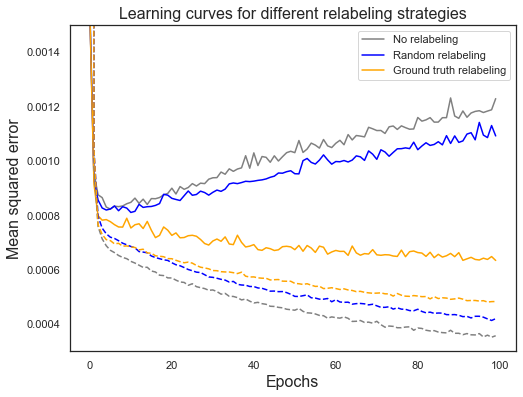

In [59]:
plt.figure(figsize=(8, 6))
plt.plot(te_loss_none, linestyle='-', c='gray', label='No relabeling')
plt.plot(te_loss_rand, linestyle='-', c='blue', label='Random relabeling')
plt.plot(te_loss_true, linestyle='-', c='orange', label='Ground truth relabeling')

plt.ylim(0.0003, 0.0015)
plt.plot(tr_loss_none, linestyle='--', c='gray')
plt.plot(tr_loss_rand, linestyle='--', c='blue')
plt.plot(tr_loss_true, linestyle='--', c='orange')

plt.legend()
plt.ylabel('Mean squared error', size=16)
plt.xlabel('Epochs', size=16)
plt.title('Learning curves for different relabeling strategies', size=16)
plt.show